# Challenge - Knowledge Graph Completion

In this challenge, we are focussing on exploiting the main tools provided in this training camp in order to find the best features to use for making our prediction on the knowledge graph.

As the first step we loaded some interisting libraries to do our work.

In [278]:
# the library for creating the graphs
import networkx as nx

# some useful machine learning libraries and not
import pandas as pd
import numpy as np
import math
from itertools import zip_longest
from collections import defaultdict
import torch
import time
from sklearn.preprocessing import *
from sklearn.metrics import *
from sklearn.metrics.pairwise import *
from sklearn.linear_model import *
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.tree import *
from contextlib import suppress

# using pykeen library for obtaining the score feature
from pykeen.pipeline import pipeline
from pykeen.models.predict import *
from pykeen.triples import TriplesFactory

In order to achieve the final score, we tasted different solutions in the following steps:

1. We compute some features 'manually':
 - Common neighbors
 - Jaccard Similarity
 - Adamic-Adar coefficient
<br><br>
2. we take into account the multi-link that two nodes may have, in order to do not lost information. For each extra link we added a new node connected with the source and target nodes.
<br> 
<br>
3. Add some new features:
 - degree, indegree, outdegree
 - num_links
 - Page Rank
 - Resource Allocation Index
 - dispersion
 - cosine similarity (computed for each combination of source, target and relation nodes)
<br>
<br>
4. Compute the embeddings and the relative score for the KG.<br>
<br>

5. Extracte rules from KG data with AMIE<br>

Once we have computed all the steps we tried some models on different combinations of features.

For the final model, a tuned random forest calssifier, we choose the following features:
- 'source_indegree'
- 'source_outdegree'
- 'target_indegree'
- 'target_outdegree'
- 'jaccard'
- 'common_neighbours'
- 'source'
- 'target'
- 'relation'
- 'score'


## Defining some utilities functions

Here, we define some utilities used in the next cells:

- for loading and saving the datasets

In [24]:
def load_df(filename, lemmatize=False): 
    '''
    :param filename: dataset
    :param lemmatize: flag to lemmatize relation column
    
    :return dataframe
    '''
    df = pd.read_csv(filename, index_col=0, sep=',')
    y = None
    
    with suppress(AttributeError):
        y = df.Label
    
    df = pd.DataFrame(df['Triple'].apply(str.split).tolist(),
                            columns=['source','relation','target'],
                     index=df.index)
    df.source = df.source.astype(int)
    df.target = df.target.astype(int)
    
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        df['relation'] = df['relation'].apply(lemmatizer.lemmatize)

    if y is not None:
        df['y'] = y
    
    return df

def save_as_keen_dataset(df, filename, filter_by_label=True):
    '''
    :param df: dataframe
    :param filename: name of tsv file
    :param filter_by_label: flag to filter the dataset
    
    :return void
    '''
    
    if filter_by_label:
        df = df[df.y==1]
    
    df.to_csv(filename, columns=['source','relation','target'], 
              header=False, index=False, sep='\t')

- for getting few features:

In [ ]:
def get_link_predictors(G, pairs):
    '''
    Given a graph and the pairs of nodes, return the dataframe with:
    a. Jaccard
    b. resource_allocation_index
    c. preferential_attachment
    
    :param G: Graph
    :param pairs: List of pairs 
    
    :return dataframe
    '''
    jaccards = np.array([x[2] for x in nx.jaccard_coefficient(G, pairs)]).reshape(-1,1)
    ra_index = np.array([x[2] for x in list(nx.resource_allocation_index(G, pairs))]).reshape(-1,1)
    pa = np.array([x[2] for x in list(nx.preferential_attachment(G, pairs))]).reshape(-1,1)
    return pd.DataFrame(np.hstack([jaccards, ra_index, pa]), columns=['jaccard','ra_index','pa'])

def get_scores(df, triples, model):
    '''
    Function to compute the score_hrt function
    
    :param df: dataframe
    :param triples: source, target and relation
    :param model: model
    
    :return score
    '''
    source_ids = triples.entities_to_ids(df.source)
    target_ids = triples.entities_to_ids(df.target)
    relation_ids = triples.relations_to_ids(df.relation)
    triples_to_be_scored = torch.LongTensor(list(zip(source_ids, relation_ids, target_ids)))
    model.cpu()
    scores = model.score_hrt(triples_to_be_scored).detach().numpy()
    return scores

def multigraph_jaccard(G, N, pairs):
    '''
    Compute the jaccard similarity taking into account the multiple relations between two nodes.
    When there are more then one link between two nodes, A and B, for each 'extra link' create a node connected between A & B.
    new_J(A,B)= |intersection| + no. of extra link / |Union| + no. of extra link 
    
    :param G: Graph
    :param N: dictionary, for each node there's a list of neighborhoods
    :param pairs: pairs of nodes
    
    :return list of jaccard similarities
    '''
    
    jaccards = list()
    
    for u, v in pairs:
        num_links = GMul_train.number_of_edges(u, v)
        num = len(set(N[u]).intersection(set(N[v]))) + max(num_links-1, 0)
        den = len(set(N[u]).union(set(N[v]))) + max(num_links - 1, 0)
        val = 0
        if den != 0:
            val = num/den
        jaccards.append(val)
        
    return jaccards

def multigraph_adamic_adar(G, N, pairs):
    '''
    Compute the adamic_adar taking into account the extra link between two nodes, A and B.
    new_aa = aa + k/log(2)
    where k is the number of 'extra link'
    
    :param G: Graph
    :param N: dictionary, for each node there's a list of neighborhoods
    :param pairs: pairs of nodes
    
    :return list of new_aa score
    '''
    
    multi_adamic = list()
    adamic = list(nx.adamic_adar_index(G, pairs))

    for ad in adamic:
        u, v, r = ad
        k = max(multilink[(u,v)]-1,0)
        x = k/np.log(2)
        multi_adamic.append(r + x)
    
    return multi_adamic

def get_multijaccard(G, df):
    '''
    Compute the elements in order to use the multigraph_jaccard function, N and pairs.
    
    :param G: Graph
    :param df: dataframe
    
    :return multigraph_jaccard()
    '''
    
    node_list = list(G.nodes)
    N = dict(zip(node_list, list(map(lambda x: list(map(int, nx.neighbors(G, x))), node_list))))
    pairs = list(zip(list(map(int, df['source'].to_list())), list(map(int, df['target'].to_list()))))
    return multigraph_jaccard(G, N, pairs)

def get_multi_adamic(G, df):
    '''
    Compute the elements in order to use the multigraph_adamic_adar function, N and pairs.
    
    :param G: Graph
    :param df: dataframe
    
    :return multigraph_adamic_adar()
    '''
    
    node_list = list(G.nodes)
    N = dict(zip(node_list, list(map(lambda x: list(map(int, nx.neighbors(G, x))), node_list))))
    pairs = list(zip(list(map(int, df['source'].to_list())), list(map(int, df['target'].to_list()))))
    return multigraph_adamic_adar(G, N, pairs)

def get_RAI(G, N, pairs): #Resource Allocation Index
    '''
    Function to compute the Resource Allocation Index 
    
    :param G: Graph
    :param N: dictionary, for each node there's a list of neighborhoods
    :param pairs: pairs of nodes
    
    :return list of rai scores
    '''
    
    rai = list()
    for u, v in pairs:
        nodes = set(list(G.neighbors(u))).intersection(list(G.neighbors(v)))
        summation = 0
        for node in nodes:
            summation+=(1/G.degree[node])
        rai.append(summation)
    
    return rai

def cosine_similarity(v1,v2):
    '''
    compute cosine similarity of v1 to v2: 
    (v1 dot v2) / (||v1||*||v2||)
    where v1!=v2
    
    :param v1: i-th row of embedding w.r.t one column of (s, t, r)
    :param v2: i-th row of embedding w.r.t one column of (s, t, r)
    
    :return cosine_similarity
    '''
    
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range(len(v1)):
        x = v1[i]; y = v2[i]
        sumxx += x*x
        sumyy += y*y
        sumxy += x*y
    return sumxy/math.sqrt(sumxx*sumyy)

- Other utilities

In [ ]:
def make_prediction(model, X_train, y_train, X_val, y_val):
    '''
    Given a model return predictions and the f1-score of the validation set
    
    :param model: model to train
    :param X_train: training set
    :param y_train: training set labels
    :param X_val: validation set
    :param y_val: validation set labels
    
    :return (y_pred, score)
    '''
    model.fit(X_train, y_train)
    y_pred = (model.predict(X_val) >= 0.5).astype(int)
    score = f1_score(y_val, y_pred)
    return y_pred, score

def get_dataset_with_predictors(df):
    '''
    return a concatenation of df with the result of the function "get_link_predictors"
    
    :param df: dataframe
    
    :return new_dataframe
    '''
    pairs = list(zip(list(map(int, df['source'].to_list())), list(map(int, df['target'].to_list()))))
    graph = nx.Graph(df_to_graph(df))
    predictors = get_link_predictors(graph, pairs)
    predictors.index = df.index
    return pd.concat([df, predictors], axis=1)

def df_to_graph(df):
    '''
    Function to convert the dataframe to graph
    
    :param df: dataframe
    
    :return graph
    '''
    return nx.from_pandas_edgelist(df, edge_attr='relation', create_using=nx.MultiDiGraph)

## Loading the datasets

In this step, we are loading the datasets provided by the training camp.

In [296]:
files = list(map(lambda x: x + ".csv", ['kg_train', 'kg_validation', 'kg_trainvalidation', 'kg_test_nolabel']))
train, val, train_val, test = list(map(lambda x: load_df(x), files))

Here, we clean and re-defining some information obtained in the datasets:

In [305]:
relation_ids = train_val.relation.astype('category').cat.codes
relation_ids_dict = dict(zip(train_val.relation, relation_ids))

In [192]:
def relation_as_id(df, relation_ids_dict):
    return [relation_ids_dict[x] for x in df.relation] 

In [306]:
train.relation = relation_as_id(train, relation_ids_dict)
val.relation = relation_as_id(val, relation_ids_dict)
train_val.relation = relation_as_id(train_val, relation_ids_dict)
test.relation = relation_as_id(test, relation_ids_dict)

After cleaning and re-defining the datasets, we saved it as .csv files.

In [75]:
save_as_keen_dataset(test, 'pykeen_test.tsv', filter_by_label=False)
save_as_keen_dataset(train_val, 'pykeen_trainval.tsv')
save_as_keen_dataset(val, 'pykeen_val.tsv')
save_as_keen_dataset(train, 'pykeen_train.tsv')

## Extracting the important features

Here, we start to define interesting pipelines for getting the score, after that we merged the features within the datasets.

In [297]:
#all_triples = TriplesFactory.from_path('pykeen_trainval.tsv')
all_triples = TriplesFactory.from_path('pykeen_train_val_with_triples.csv')
# train_triples = TriplesFactory.from_path('pykeen_train.tsv')
# val_triples = TriplesFactory.from_path('pykeen_val.tsv')

trainset_percentage = 0.8
train_triples, val_triples = all_triples.split(ratios=trainset_percentage)

INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [63979, 26231]


Here, we are using the basics pipeline used in PyKeen. 

This is a python library for training and evaluating KGE; here we considered the model ***TransH***, instead of ***TransE*** because performs better than this. The number of embeddings is setted as default (50) and the number of epochs is still fixed at 200. We tried different configurations but, these were suitables for our purposes.

In [298]:
result = pipeline(
    training=train_triples,
    testing=val_triples,
    model='TransH',
    model_kwargs = dict(
        #relation_dim=100, #dimensionality of the relation embeddings; default: 50; 
                          #in some models (like TransE) relation_dim cannot be set: it is assumed to be equal to embedding_dim
        #embedding_dim=200 #dimensionality of the netity embeddings; default: 50
    ),
    loss_kwargs = dict(), #loss configuration
    training_loop='SLCWATrainingLoop', #default: 'SLCWATrainingLoop'; https://pykeen.readthedocs.io/en/stable/reference/training.html
    regularizer='LpRegularizer', #default: 'NoRegularizer'; https://pykeen.readthedocs.io/en/stable/reference/regularizers.html
    #regularizer configuration
    regularizer_kwargs=dict(
        p=2.0, #default: 2.0
        weight=1.0 #default: 1.0
    ),
    optimizer='SGD', #default: torch.optim.Adagrad; https://pytorch.org/docs/stable/optim.html%23torch.optim
    #optimizer configuration
    optimizer_kwargs = dict(
        lr=0.1
    ),
    negative_sampler='Basic', #default: 'Basic' (pykeen.sampling.BasicNegativeSampler); only allowed with training_loop='SLCWATrainingLoop'
    dimensions=200, #default: 50
    #training configuration
    training_kwargs=dict(
        num_epochs=200,
        use_tqdm_batch=False,
    ),  
    #runtime configuration
    random_seed=1234,
    device='gpu'#device='cpu'
)

Training epochs on cuda:   0%|          | 0/200 [00:00<?, ?epoch/s]

INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=128.


Evaluating on cuda:   0%|          | 0.00/26.2k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 65.69s seconds


This is the plot that shows the losses during each epochs.

<AxesSubplot:title={'center':'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

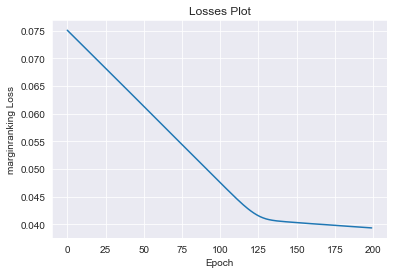

In [299]:
result.plot_losses()

Here, we define two functions for handling the embeddings obtained in the PyKeen pipeline.

In [14]:
def get_embeddings(triples): 
    '''
    Function to compute the entity and relation embeddings
    
    :param triples: (s, t, r)
    
    :param entity2embedding, relation2embedding
    '''
    
    #extract entity embeddings
    entity_ids = torch.LongTensor(range(triples.num_entities))
    e_emb = result.model.entity_embeddings
    e_emb.cpu()
    e_emb_numpy = e_emb(entity_ids).detach().numpy()
    entity2embedding = {}
    for eid in range(triples.num_entities):
      e = triples.entity_id_to_label[eid]
      entity2embedding[e] = list(e_emb_numpy[eid])
    
    #extract relation embeddings
    relation_ids = torch.LongTensor(range(triples.num_relations))
    r_emb = result.model.relation_embeddings
    r_emb.cpu()
    r_emb_numpy = r_emb(relation_ids).detach().numpy()
    relation2embedding = {}
    for rid in range(triples.num_relations):
      r = triples.relation_id_to_label[rid]
      relation2embedding[r] = list(r_emb_numpy[rid])
    
    return entity2embedding, relation2embedding

def add_embeddings(df, entity_emb_dict, relation_emb_dict, binary_operator=cosine_similarity):
    '''
    Add the embeddings to the dataframe df.
    
    :param df: dataframe
    :param entity_emb_dict: entity2embedding retured by get_embeddings()
    :param relation_emb_dict: relation2embedding retured by get_embeddings()
    :param binary_operator:
    
    :return dataframe + [df, sr_dist, rt_dist, st_dist]
    '''
    
    source_emb = df.source.apply(lambda x: entity_emb_dict[str(x)]).to_list()
    target_emb = df.target.apply(lambda x: entity_emb_dict[str(x)]).to_list()
    relation_emb = df.relation.apply(lambda x: relation_emb_dict[str(x)]).to_list()
    df_emb = pd.DataFrame(np.hstack((source_emb, target_emb, relation_emb)), index=df.index)
    n = len(source_emb)
    sr_dist = pd.DataFrame([binary_operator(source_emb[i], relation_emb[i]) for i in range(n)], index=df.index, columns=['sr_dist'])
    rt_dist = pd.DataFrame([binary_operator(relation_emb[i], target_emb[i]) for i in range(n)], index=df.index, columns=['rt_dist'])
    st_dist = pd.DataFrame([binary_operator(source_emb[i], target_emb[i]) for i in range(n)], index=df.index, columns=['st_dist'])
    return pd.concat([df, sr_dist, rt_dist, st_dist], axis=1)

Here, we handle and store the embeddings.

In [300]:
entity_emb_dict, relation_emb_dict = get_embeddings(train_triples)

Here, we add the embeddings in each dataframes created before.

In [307]:
train_with_emb = add_embeddings(train, entity_emb_dict, relation_emb_dict)
test_with_emb = add_embeddings(test, entity_emb_dict, relation_emb_dict)
val_with_emb = add_embeddings(val, entity_emb_dict, relation_emb_dict)
trainval_with_emb = add_embeddings(train_val, entity_emb_dict, relation_emb_dict)
train_val_rules_with_emb = add_embeddings(train_val_with_rules, entity_emb_dict, relation_emb_dict)

Here we define the portions of datasets.

In [309]:
X_train = train_with_emb.drop('y', axis=1)
y_train = train_with_emb.y

X_val = val_with_emb.drop('y', axis=1)
y_val = val_with_emb.y

X_train_val = trainval_with_emb.drop('y', axis=1)
y_train_val = trainval_with_emb.y

X_test = test_with_emb

X_train_val_rules = train_val_rules_with_emb.drop('y', axis=1)
y_train_val_rules = train_val_rules_with_emb.y

... adding the score feature

In [310]:
X_train['score'] = get_scores(train, train_triples, result.model)
X_test['score'] = get_scores(test, train_triples, result.model)
X_val['score'] = get_scores(val, train_triples, result.model)
X_train_val['score'] = get_scores(train_val, train_triples, result.model)
X_train_val_rules['score'] = get_scores(train_val_with_rules, train_triples, result.model)

... creating the main graph to consider

In [311]:
GMul = df_to_graph(train_val_with_rules)
GMul_simple = nx.Graph(GMul)

... getting few features from the graph created

In [312]:
pr = nx.algorithms.link_analysis.pagerank_alg.pagerank(nx.Graph(GMul))
clustering = nx.algorithms.cluster.clustering(GMul_simple)
in_degrees = dict(GMul.in_degree)
out_degrees = dict(GMul.out_degree)

For each dataset shown below, we decide to add all these features. This allows us to see which is the best combination of features to handle in the classifier.

In [313]:
datasets = [X_train, X_val, X_train_val, X_test, X_train_val_rules]

for i,dataset in enumerate(datasets):
    pairs = list(zip(dataset.source.to_list(), dataset.target.to_list()))
    dataset['jaccard'] = [x[2] for x in list(nx.jaccard_coefficient(GMul_simple, pairs))]
    dataset['pr_diff'] = [np.sqrt(abs(pr[x[0]]-pr[x[1]])+1e-7)*10e4 for x in pairs]
    dataset['pr_posterior'] = [np.sqrt(pr[x[0]]*pr[x[1]]+1e-7)*10e4 for x in pairs]
    dataset['source_pr'] = [pr[x]*10e4 for x in dataset.source.to_list()]
    dataset['target_pr'] = [pr[x]*10e4 for x in dataset.target.to_list()]
    dataset['source_clustering'] = [clustering[x] for x in dataset.source.to_list()]
    dataset['target_clustering'] = [clustering[x] for x in dataset.target.to_list()]
    dataset['common_neighbours'] = [len(list(nx.common_neighbors(GMul_simple, x[0], x[1]))) for x in pairs]
    dataset['source_indegree'] = [in_degrees[x] for x in dataset.source]
    dataset['target_indegree'] = [in_degrees[x] for x in dataset.target]
    dataset['source_outdegree'] = [out_degrees[x] for x in dataset.source]
    dataset['target_outdegree'] = [out_degrees[x] for x in dataset.target]
    dataset['num_links'] = [GMul.number_of_edges(x[0], x[1]) for x in pairs]
    dataset['group_degree_centrality'] = [nx.group_degree_centrality(GMul, [x[0], x[1]]) for x in pairs]
    ##dataset['group_betweenness_centrality'] = [nx.group_betweenness_centrality(graphs[i], [x[0], x[1]]) for x in pairs]
    ##dataset['group_closeness_centrality'] = [nx.group_closeness_centrality(graphs[i], [x[0], x[1]]) for x in pairs]
    dataset['dispersion'] = [nx.dispersion(GMul, x[0], x[1]) for x in pairs]
    #dataset['bidirectional_shortest_path'] = [len(nx.bidirectional_shortest_path(GMul, x[0], x[1])) for x in pairs]#bidirectional_shortest_path
    ##dataset['bidirectional_shortest_path'] = [nx.minimum_cut(nx.Graph(graphs[i]), x[0], x[1]) for x in pairs]#minimum_cut(flowG, _s, _t)
    dataset['rai'] = get_RAI(GMul, dataset, pairs)

We tried different combinations, but these features reported below give a better performance with our classifier. At the end, we saw that these features are the best and these are used in this training camp, amazing!

In [320]:
cols = ['source_indegree', 'source_outdegree', 'target_indegree', 'target_outdegree',
        'jaccard', 'common_neighbours', 'source', 'target', 'relation', 'score']

## Training and test the model

After defining the features in the datasets, we can start to train the model.

In [ ]:
for i in range(1, len(X_train.columns)+1):
    pred, score = make_prediction(DecisionTreeClassifier(),
                                  normalize(X_train.iloc[:,:i]), y_train,
                                  normalize(X_val.iloc[:,:i]), y_val)
    print(X_train.columns[i], round(score*100, 2))

In [145]:
best_pred = pd.read_csv('submission_26.csv', sep=',', index_col=0)
best_pred.head()

,Predicted
Id,
114754,0
114755,0
114756,1
114757,0
114758,1


In [146]:
best_pred.sum()

Predicted    15111
dtype: int64

In [314]:
cross_val_score(RandomForestClassifier(random_state=0), X_train_val_rules,
                y_train_val_rules, scoring=make_scorer(f1_score)).mean()

0.8924472525138245

We prefer using the random forest classifier, because it gives the best performance, before we tried to use the LogisticRegression(), SVM() etc. But this is the best model to use.

In [321]:
lr = RandomForestClassifier(random_state=0, max_depth=20, n_estimators=200)
lr.fit(X_train_val_rules[cols], y_train_val_rules)
y_pred = lr.predict(X_test[cols])
y_pred.sum()

16708

In [318]:
X_train_val_rules

,source,relation,target,jaccard,pr_diff,pr_posterior,source_pr,target_pr,source_clustering,target_clustering,...,source_outdegree,target_outdegree,num_links,group_degree_centrality,dispersion,rai,sr_dist,rt_dist,st_dist,score
0,37997,445,37996,0.0,230.126174,31.644383,0.937904,1.457484,0.000000,0.000000,...,1,0,1,0.000000,0.0,0.0,-0.127619,-0.078162,0.792501,-2.341326
1,1830,445,17796,0.0,520.680798,31.699313,1.232175,3.933260,0.000000,0.000000,...,1,0,1,0.000000,0.0,0.0,-0.154176,-0.184963,0.736959,-2.681203
2,42082,445,241,0.0,417.900915,31.683141,1.270762,3.007174,0.000000,0.000000,...,1,0,1,0.000000,0.0,0.0,-0.043348,-0.082051,0.786942,-2.449785
3,4490,445,4475,0.0,755.798683,31.733339,1.039073,6.741389,0.000000,0.000000,...,1,0,1,0.000000,0.0,0.0,-0.205677,-0.174397,0.808179,-2.356881
4,17824,445,17796,0.0,520.680798,31.699313,1.232175,3.933260,0.000000,0.000000,...,1,0,1,0.000000,0.0,0.0,-0.085301,-0.184963,0.818001,-2.111751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114749,13283,1468,30936,0.0,595.391027,31.699099,4.588231,1.053327,0.051471,0.000000,...,12,2,1,0.000210,0.0,0.0,0.230841,0.139674,0.819506,-2.649781
114750,12592,1529,11190,0.0,133.428758,31.744829,2.698290,2.866322,0.000000,0.000000,...,2,2,1,0.000049,0.0,0.0,-0.057981,0.034705,0.845825,-1.980564
114751,30904,1464,17034,0.0,400.505396,31.664654,1.015589,2.609634,0.000000,0.027778,...,1,9,1,0.000113,0.0,0.0,0.107285,0.065901,0.802370,-2.717993
114752,21968,2193,4930,0.0,277.273138,31.703102,2.666464,1.907660,0.027778,0.000000,...,7,1,1,0.000113,0.0,0.0,-0.016071,0.082472,0.774801,-2.682530


In [323]:
(y_pred == best_pred.Predicted).mean()

0.8589403973509934

In [324]:
submission = pd.DataFrame(y_pred, columns=['Predicted'], index=X_test.index)
submission.to_csv('submission_28.csv', sep=',', index_label='Id')

In [284]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val_rules, y_train_val_rules, train_size=0.8)

In [285]:
pred, score = make_prediction(RandomForestClassifier(random_state=0, max_depth=20, n_estimators=200),
                              X_train, y_train, X_val, y_val)
score

0.9534698810508236

We search to find the best parameters for our model, we consider the random forest classifier because it gives the best results.

In [ ]:
param_grid = {
    'max_depth': [5, 10, 20],
    'n_estimators': [50, 100, 200]    
}

gs = GridSearchCV(RandomForestClassifier(random_state=0), param_grid=param_grid, verbose=2)
gs.fit(X_train_val, y_train_val)
gs.best_params_

## Trying to adding other extra rows on our datasets

Here, we decide to insert different rules in order to be able to insert more rows, this maybe could bring us to have better results, so here we put the procedure where adding the extra examples to the main datasets.

In [153]:
!java -XX:-UseGCOverheadLimit -jar amie/amie-dev.jar pykeen_trainval.tsv 2>amie-output >amie-rules

In [156]:
!grep "=>" amie-rules > rules

In [157]:
!head rules

?b  1524  ?a   => ?a  445  ?b	0,023622047	0,066666667	0,115384615	3	45	26	?b
?b  1505  ?a   => ?a  445  ?b	0,062992126	0,131147541	0,333333333	8	61	24	?b
?a  537  ?b   => ?a  2359  ?b	0,011904762	0,055555556	1	2	36	2	?b
?a  1982  ?b   => ?a  1430  ?b	0,037190083	0,085714286	1	9	105	9	?b
?b  246  ?a   => ?a  2359  ?b	0,011904762	0,046511628	0,5	2	43	4	?b
?b  499  ?a   => ?a  2359  ?b	0,166666667	0,1352657	0,682926829	28	207	41	?b
?b  943  ?a   => ?a  1430  ?b	0,016528926	0,01	0,235294118	4	400	17	?b
?a  960  ?b   => ?a  1430  ?b	0,012396694	0,009036145	0,214285714	3	332	14	?b
?a  1814  ?b   => ?a  1430  ?b	0,016528926	0,051282051	0,571428571	4	78	7	?b
?b  1463  ?a   => ?a  1468  ?b	0,101010101	0,09375	0,3	30	320	100	?a


In [161]:
# Load KG by relations 
kgfile = "pykeen_trainval.tsv"
rulefile = "rules"
kg = pd.read_csv(kgfile, sep='\t', header=None)

In [169]:
kg.head()

,0,1,2
0,29942,788,29955
1,31176,1960,14389
2,112,1665,119
3,32439,1057,32441
4,37539,1661,37540


In [183]:
# load kg a relation 2 valid triples dictionary
relation2triples = defaultdict(list)

for i in kg.iterrows():
    source = i[1][0]
    tail = i[1][2]
    relation = i[1][1]
    relation2triples[str(relation)].append((str(source), str(tail)))
len(relation2triples)

2533

In [164]:
# load each rule as a tuple of 2 element: body (a list of triples) and head (a single triple)
# body will contain either 1 or 2 triples
def group_elements(n, iterable, padvalue='?'):
    '''
    Function to obtain the group elements
    
    :param n: number of times
    :param iterable: number of iterations to be iterable
    :param padvalue: use the value for padding the miss info
    
    return list of info
    '''
        
    return list(zip_longest(*[iter(iterable)]*n, fillvalue=padvalue))

def load_rules(rulefile):
    '''
    Function to load the rules
    
    :param rulefile: file to iterate
    
    return the list of rules
    '''
        
    with open(rulefile) as f:
        rlines = f.readlines()
        print(len(rlines))
        rules = []
        rleng = []
        for k,rline in enumerate(rlines):
            rule = rline.split('\t')[0]
            body = rule.split('=>')[0]
            head = rule.split('=>')[1]
            body_elements = body.split(' ')
            body_elements = list(filter(lambda x: x != "", body_elements))
            head_elements = head.split(' ')
            head_elements = list(filter(lambda x: x != "", head_elements))
            
            body_triples = group_elements(3,body_elements)
            head_triple = group_elements(3,head_elements)[0]
            rleng.append(len(body_triples))         
            rules.append((body_triples, head_triple))
    return (rules, rleng)

In [165]:
(rules, rleng) = load_rules(rulefile)

1213


In [173]:
rules[0]

([('?b', '1524', '?a')], ('?a', '445', '?b'))

In [166]:
def instantiate_rule(relation2triples, rule):
    '''
    Function to instantiate the rules
    
    :param relation2triples: relation to consider for getting triples
    :param rule: the rule to respect
    
    return instatiate the rules
    '''
        
    rule_body_triples = rule[0]
    rule_head_triple = rule[1]
    
    instantiated_rules = []
    new_inferred_triples = []
    
    if len(rule_body_triples) == 1:
        body_source = rule_body_triples[0][0]
        body_relation = rule_body_triples[0][1]
        body_tail = rule_body_triples[0][2]
        
        head_source = rule_head_triple[0]
        head_relation = rule_head_triple[1]
        head_tail = rule_head_triple[2]
        
        body_relation_triples = relation2triples[body_relation]

        
        for (source, tail) in body_relation_triples:
            if (body_source == head_source):
                rule_instance = '%s %s %s => %s %s %s' % (source, body_relation, tail, source, head_relation, tail)
                instantiated_rules.append(rule_instance)
              
                if (source, tail) not in relation2triples[head_relation]:
                    new_inferred_triples.append((source, head_relation, tail))
            else:
                rule_instance = '%s %s %s => %s %s %s' % (source, body_relation, tail, tail, head_relation, source)
                instantiated_rules.append(rule_instance)
                if (tail, source) not in relation2triples[head_relation]:
                    new_inferred_triples.append((tail, head_relation, source))
                
    else: # body has 2 triples
        body_first_source = rule_body_triples[0][0]
        body_first_relation = rule_body_triples[0][1]
        body_first_tail = rule_body_triples[0][2]
        
        body_second_source = rule_body_triples[1][0]
        body_second_relation = rule_body_triples[1][1]
        body_second_tail = rule_body_triples[1][2]
        
        body_first_triples = relation2triples[body_first_relation]
        
        body_second_triples = relation2triples[body_second_relation]
        
        head_source = rule_head_triple[0]
        head_relation = rule_head_triple[1]
        head_tail = rule_head_triple[2]
        
        distinct_variables = list(set([body_first_source, body_first_tail, body_second_source, body_second_tail]))
        print(len(distinct_variables))
        
        derived_pairs = []
        
        
        for (first_source, first_tail) in body_first_triples:
            for (second_source, second_tail) in body_second_triples:
                valid = 1
               
                if body_first_source == body_second_source and first_source != second_source:
                    valid = 0
                                                    
                if body_first_source == body_second_tail and first_source != second_tail:
                    valid = 0
                                                
                if body_first_tail == body_second_source and first_tail != second_source:
                    valid = 0
            
                if body_first_tail == body_second_tail and first_tail != second_tail:
                    valid = 0
                        
                if valid == 0:
                    continue
                        
                
                hsource = ''
                htail = ''
                
                if head_source == body_first_source:
                    hsource = first_source
                elif head_source == body_first_tail:
                    hsource = first_tail
                elif head_source == body_second_source:
                    hsource = second_source
                elif head_source == body_second_tail:
                    hsource = second_tail
                        
                if head_tail == body_first_source:
                    htail = first_source
                elif head_tail == body_first_tail:
                    htail = first_tail
                elif head_tail == body_second_source:
                    htail = second_source
                elif head_tail == body_second_source:
                    htail = second_tail
                
         
                
                rule_instance = '%s %s %s AND %s %s %s => %s %s %s' %  (first_source, body_first_relation, first_tail, second_source, body_second_relation, second_tail, hsource, head_relation, htail)
                instantiated_rules.append(rule_instance)
      
                if (hsource, htail) not in relation2triples[head_relation]:
                    new_inferred_triples.append((hsource, head_relation, htail))

    
    return (instantiated_rules, new_inferred_triples)

In [185]:
all_instances = []
all_new_triples = []

start_time = time.time()
for k, rule in enumerate(rules):
    print('Processing RULE # %d \n'% k)
    print(rule)
    (instances, new_triples) = instantiate_rule(relation2triples, rule)
    print('Found Instances: %d\n' % (len(instances)))
    print('New triples inferred: %d\n' % (len(new_triples)))
    all_instances.extend(instances)
    all_new_triples.extend(new_triples)
elapsed = time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))
print(f"Took: {elapsed}")

Processing RULE # 0 

([('?b', '1524', '?a')], ('?a', '445', '?b'))
Found Instances: 45

New triples inferred: 42

Processing RULE # 1 

([('?b', '1505', '?a')], ('?a', '445', '?b'))
Found Instances: 61

New triples inferred: 53

Processing RULE # 2 

([('?a', '537', '?b')], ('?a', '2359', '?b'))
Found Instances: 36

New triples inferred: 34

Processing RULE # 3 

([('?a', '1982', '?b')], ('?a', '1430', '?b'))
Found Instances: 105

New triples inferred: 96

Processing RULE # 4 

([('?b', '246', '?a')], ('?a', '2359', '?b'))
Found Instances: 43

New triples inferred: 41

Processing RULE # 5 

([('?b', '499', '?a')], ('?a', '2359', '?b'))
Found Instances: 207

New triples inferred: 179

Processing RULE # 6 

([('?b', '943', '?a')], ('?a', '1430', '?b'))
Found Instances: 400

New triples inferred: 396

Processing RULE # 7 

([('?a', '960', '?b')], ('?a', '1430', '?b'))
Found Instances: 332

New triples inferred: 329

Processing RULE # 8 

([('?a', '1814', '?b')], ('?a', '1430', '?b'))
Fou


New triples inferred: 296

Processing RULE # 95 

([('?a', '185', '?b')], ('?a', '1499', '?b'))
Found Instances: 196

New triples inferred: 185

Processing RULE # 96 

([('?a', '44', '?b')], ('?a', '1499', '?b'))
Found Instances: 150

New triples inferred: 144

Processing RULE # 97 

([('?b', '387', '?a')], ('?a', '807', '?b'))
Found Instances: 95

New triples inferred: 90

Processing RULE # 98 

([('?b', '1120', '?a')], ('?a', '807', '?b'))
Found Instances: 229

New triples inferred: 190

Processing RULE # 99 

([('?a', '1244', '?b')], ('?a', '1906', '?b'))
Found Instances: 31

New triples inferred: 24

Processing RULE # 100 

([('?a', '1246', '?b')], ('?a', '1906', '?b'))
Found Instances: 25

New triples inferred: 22

Processing RULE # 101 

([('?a', '1250', '?b')], ('?a', '1906', '?b'))
Found Instances: 3

New triples inferred: 1

Processing RULE # 102 

([('?a', '1787', '?b')], ('?a', '1906', '?b'))
Found Instances: 76

New triples inferred: 74

Processing RULE # 103 

([('?a', '2

New triples inferred: 152

Processing RULE # 197 

([('?a', '1481', '?b')], ('?a', '1753', '?b'))
Found Instances: 198

New triples inferred: 190

Processing RULE # 198 

([('?b', '1748', '?a')], ('?a', '1481', '?b'))
Found Instances: 52

New triples inferred: 29

Processing RULE # 199 

([('?b', '1149', '?a')], ('?a', '1481', '?b'))
Found Instances: 18

New triples inferred: 16

Processing RULE # 200 

([('?b', '1753', '?a')], ('?a', '1481', '?b'))
Found Instances: 151

New triples inferred: 105

Processing RULE # 201 

([('?a', '1753', '?b')], ('?a', '1481', '?b'))
Found Instances: 151

New triples inferred: 143

Processing RULE # 202 

([('?b', '347', '?a')], ('?a', '683', '?b'))
Found Instances: 106

New triples inferred: 104

Processing RULE # 203 

([('?a', '2175', '?b')], ('?a', '1874', '?b'))
Found Instances: 16

New triples inferred: 14

Processing RULE # 204 

([('?a', '310', '?b')], ('?a', '1874', '?b'))
Found Instances: 124

New triples inferred: 119

Processing RULE # 205 

Found Instances: 128

New triples inferred: 110

Processing RULE # 276 

([('?h', '1462', '?a'), ('?b', '1465', '?h')], ('?a', '1468', '?b'))
3
Found Instances: 114

New triples inferred: 105

Processing RULE # 277 

([('?h', '1463', '?a'), ('?b', '1467', '?h')], ('?a', '1468', '?b'))
3
Found Instances: 108

New triples inferred: 99

Processing RULE # 278 

([('?h', '1468', '?b'), ('?a', '1469', '?h')], ('?a', '1468', '?b'))
3
Found Instances: 126

New triples inferred: 110

Processing RULE # 279 

([('?b', '1465', '?h'), ('?a', '1469', '?h')], ('?a', '1468', '?b'))
3
Found Instances: 135

New triples inferred: 114

Processing RULE # 280 

([('?h', '1467', '?b'), ('?a', '1469', '?h')], ('?a', '1468', '?b'))
3
Found Instances: 121

New triples inferred: 92

Processing RULE # 281 

([('?h', '1466', '?b'), ('?a', '1469', '?h')], ('?a', '1468', '?b'))
3
Found Instances: 123

New triples inferred: 84

Processing RULE # 282 

([('?h', '1465', '?b'), ('?a', '1466', '?h')], ('?a', '1468', '?b'


New triples inferred: 62

Processing RULE # 345 

([('?g', '1467', '?a'), ('?g', '815', '?b')], ('?a', '815', '?b'))
3
Found Instances: 133

New triples inferred: 133

Processing RULE # 346 

([('?g', '1464', '?a'), ('?g', '815', '?b')], ('?a', '815', '?b'))
3
Found Instances: 146

New triples inferred: 146

Processing RULE # 347 

([('?g', '1469', '?a'), ('?g', '815', '?b')], ('?a', '815', '?b'))
3
Found Instances: 164

New triples inferred: 164

Processing RULE # 348 

([('?a', '2445', '?h'), ('?h', '573', '?b')], ('?a', '2446', '?b'))
3
Found Instances: 22

New triples inferred: 22

Processing RULE # 349 

([('?g', '1466', '?a'), ('?g', '815', '?b')], ('?a', '815', '?b'))
3
Found Instances: 152

New triples inferred: 152

Processing RULE # 350 

([('?g', '1462', '?a'), ('?g', '815', '?b')], ('?a', '815', '?b'))
3
Found Instances: 132

New triples inferred: 132

Processing RULE # 351 

([('?g', '1465', '?a'), ('?g', '815', '?b')], ('?a', '815', '?b'))
3
Found Instances: 147

New tri

Found Instances: 84

New triples inferred: 59

Processing RULE # 409 

([('?h', '1462', '?b'), ('?a', '1465', '?h')], ('?a', '1464', '?b'))
3
Found Instances: 114

New triples inferred: 100

Processing RULE # 410 

([('?a', '1463', '?h'), ('?h', '1467', '?b')], ('?a', '1464', '?b'))
3
Found Instances: 106

New triples inferred: 106

Processing RULE # 411 

([('?a', '1462', '?h'), ('?h', '1465', '?b')], ('?a', '1464', '?b'))
3
Found Instances: 119

New triples inferred: 119

Processing RULE # 412 

([('?h', '1462', '?b'), ('?a', '1463', '?h')], ('?a', '1464', '?b'))
3
Found Instances: 95

New triples inferred: 63

Processing RULE # 413 

([('?a', '1462', '?h'), ('?h', '1464', '?b')], ('?a', '1464', '?b'))
3
Found Instances: 108

New triples inferred: 108

Processing RULE # 414 

([('?a', '1462', '?h'), ('?h', '1463', '?b')], ('?a', '1464', '?b'))
3
Found Instances: 104

New triples inferred: 104

Processing RULE # 415 

([('?g', '1463', '?b'), ('?g', '1469', '?a')], ('?a', '1464', '?b')

Found Instances: 123

New triples inferred: 123

Processing RULE # 470 

([('?a', '1057', '?h'), ('?h', '308', '?b')], ('?a', '1057', '?b'))
3
Found Instances: 3

New triples inferred: 3

Processing RULE # 471 

([('?h', '1407', '?b'), ('?a', '1878', '?h')], ('?a', '1407', '?b'))
3
Found Instances: 8

New triples inferred: 6

Processing RULE # 472 

([('?h', '2098', '?b'), ('?a', '401', '?h')], ('?a', '2098', '?b'))
3
Found Instances: 4

New triples inferred: 1

Processing RULE # 473 

([('?g', '1407', '?b'), ('?g', '1878', '?a')], ('?a', '1407', '?b'))
3
Found Instances: 20

New triples inferred: 18

Processing RULE # 474 

([('?a', '1717', '?h'), ('?h', '2098', '?b')], ('?a', '2098', '?b'))
3
Found Instances: 9

New triples inferred: 9

Processing RULE # 475 

([('?g', '1717', '?a'), ('?g', '2098', '?b')], ('?a', '2098', '?b'))
3
Found Instances: 19

New triples inferred: 19

Processing RULE # 476 

([('?a', '1665', '?h'), ('?h', '479', '?b')], ('?a', '479', '?b'))
3
Found Instances:

Found Instances: 45

New triples inferred: 39

Processing RULE # 545 

([('?b', '1503', '?h'), ('?a', '1504', '?h')], ('?a', '2475', '?b'))
3
Found Instances: 30

New triples inferred: 25

Processing RULE # 546 

([('?a', '2138', '?h'), ('?b', '2140', '?h')], ('?a', '2475', '?b'))
3
Found Instances: 50

New triples inferred: 35

Processing RULE # 547 

([('?a', '1504', '?h'), ('?h', '2138', '?b')], ('?a', '2475', '?b'))
3
Found Instances: 55

New triples inferred: 55

Processing RULE # 548 

([('?h', '1501', '?b'), ('?a', '2475', '?h')], ('?a', '2475', '?b'))
3
Found Instances: 107

New triples inferred: 102

Processing RULE # 549 

([('?a', '1504', '?h'), ('?h', '2141', '?b')], ('?a', '2475', '?b'))
3
Found Instances: 41

New triples inferred: 41

Processing RULE # 550 

([('?a', '1501', '?h'), ('?b', '1503', '?h')], ('?a', '2475', '?b'))
3
Found Instances: 47

New triples inferred: 36

Processing RULE # 551 

([('?b', '1503', '?h'), ('?h', '2138', '?a')], ('?a', '2475', '?b'))
3
Foun

3
Found Instances: 372

New triples inferred: 345

Processing RULE # 624 

([('?b', '1918', '?h'), ('?h', '2116', '?a')], ('?a', '2116', '?b'))
3
Found Instances: 17

New triples inferred: 11

Processing RULE # 625 

([('?a', '2300', '?h'), ('?b', '2300', '?h')], ('?a', '2116', '?b'))
3
Found Instances: 79

New triples inferred: 63

Processing RULE # 626 

([('?a', '1917', '?h'), ('?b', '2116', '?h')], ('?a', '2116', '?b'))
3
Found Instances: 10

New triples inferred: 4

Processing RULE # 627 

([('?h', '1918', '?a'), ('?b', '2116', '?h')], ('?a', '2116', '?b'))
3
Found Instances: 16

New triples inferred: 10

Processing RULE # 628 

([('?a', '1918', '?h'), ('?h', '2116', '?b')], ('?a', '2116', '?b'))
3
Found Instances: 17

New triples inferred: 17

Processing RULE # 629 

([('?a', '1917', '?h'), ('?h', '2116', '?b')], ('?a', '2116', '?b'))
3
Found Instances: 31

New triples inferred: 31

Processing RULE # 630 

([('?g', '1917', '?b'), ('?g', '2116', '?a')], ('?a', '2116', '?b'))
3
Fou

Found Instances: 79

New triples inferred: 62

Processing RULE # 689 

([('?b', '2475', '?a'), ('?a', '711', '?b')], ('?a', '1503', '?b'))
2
Found Instances: 75

New triples inferred: 71

Processing RULE # 690 

([('?b', '2138', '?h'), ('?h', '2475', '?a')], ('?a', '1503', '?b'))
3
Found Instances: 94

New triples inferred: 88

Processing RULE # 691 

([('?h', '1504', '?a'), ('?b', '2138', '?h')], ('?a', '1503', '?b'))
3
Found Instances: 58

New triples inferred: 54

Processing RULE # 692 

([('?h', '2138', '?a'), ('?b', '2475', '?h')], ('?a', '1503', '?b'))
3
Found Instances: 96

New triples inferred: 88

Processing RULE # 693 

([('?b', '1504', '?h'), ('?h', '2138', '?a')], ('?a', '1503', '?b'))
3
Found Instances: 55

New triples inferred: 51

Processing RULE # 694 

([('?b', '2138', '?h'), ('?a', '711', '?h')], ('?a', '1503', '?b'))
3
Found Instances: 77

New triples inferred: 57

Processing RULE # 695 

([('?a', '1501', '?h'), ('?b', '1504', '?h')], ('?a', '1503', '?b'))
3
Found In

Found Instances: 113

New triples inferred: 109

Processing RULE # 748 

([('?h', '1467', '?a'), ('?b', '1468', '?h')], ('?a', '1463', '?b'))
3
Found Instances: 91

New triples inferred: 82

Processing RULE # 749 

([('?b', '1468', '?h'), ('?a', '1469', '?h')], ('?a', '1463', '?b'))
3
Found Instances: 107

New triples inferred: 76

Processing RULE # 750 

([('?a', '1465', '?h'), ('?b', '1468', '?h')], ('?a', '1463', '?b'))
3
Found Instances: 81

New triples inferred: 60

Processing RULE # 751 

([('?b', '1467', '?h'), ('?h', '1469', '?a')], ('?a', '1463', '?b'))
3
Found Instances: 125

New triples inferred: 104

Processing RULE # 752 

([('?b', '1467', '?h'), ('?h', '1468', '?a')], ('?a', '1463', '?b'))
3
Found Instances: 102

New triples inferred: 97

Processing RULE # 753 

([('?a', '1462', '?h'), ('?b', '1467', '?h')], ('?a', '1463', '?b'))
3
Found Instances: 123

New triples inferred: 93

Processing RULE # 754 

([('?a', '1464', '?h'), ('?b', '1467', '?h')], ('?a', '1463', '?b'))
3

Found Instances: 9

New triples inferred: 9

Processing RULE # 813 

([('?a', '2403', '?h'), ('?b', '536', '?h')], ('?a', '499', '?b'))
3
Found Instances: 12

New triples inferred: 9

Processing RULE # 814 

([('?g', '1717', '?a'), ('?g', '499', '?b')], ('?a', '499', '?b'))
3
Found Instances: 20

New triples inferred: 20

Processing RULE # 815 

([('?g', '499', '?b'), ('?g', '711', '?a')], ('?a', '499', '?b'))
3
Found Instances: 26

New triples inferred: 23

Processing RULE # 816 

([('?b', '1055', '?h'), ('?a', '2114', '?h')], ('?a', '2369', '?b'))
3
Found Instances: 5

New triples inferred: 3

Processing RULE # 817 

([('?g', '2141', '?a'), ('?g', '499', '?b')], ('?a', '499', '?b'))
3
Found Instances: 22

New triples inferred: 22

Processing RULE # 818 

([('?g', '2140', '?a'), ('?g', '499', '?b')], ('?a', '499', '?b'))
3
Found Instances: 21

New triples inferred: 21

Processing RULE # 819 

([('?a', '1120', '?h'), ('?h', '2240', '?b')], ('?a', '2240', '?b'))
3
Found Instances: 28

N

Found Instances: 91

New triples inferred: 80

Processing RULE # 882 

([('?b', '1462', '?h'), ('?a', '1468', '?h')], ('?a', '1469', '?b'))
3
Found Instances: 67

New triples inferred: 63

Processing RULE # 883 

([('?b', '1463', '?h'), ('?a', '1469', '?h')], ('?a', '1469', '?b'))
3
Found Instances: 91

New triples inferred: 86

Processing RULE # 884 

([('?b', '1462', '?h'), ('?a', '1466', '?h')], ('?a', '1469', '?b'))
3
Found Instances: 84

New triples inferred: 77

Processing RULE # 885 

([('?a', '1468', '?h'), ('?b', '1468', '?h')], ('?a', '1469', '?b'))
3
Found Instances: 377

New triples inferred: 361

Processing RULE # 886 

([('?h', '1462', '?a'), ('?b', '1466', '?h')], ('?a', '1469', '?b'))
3
Found Instances: 99

New triples inferred: 95

Processing RULE # 887 

([('?h', '1464', '?a'), ('?b', '1466', '?h')], ('?a', '1469', '?b'))
3
Found Instances: 107

New triples inferred: 89

Processing RULE # 888 

([('?b', '1468', '?h'), ('?a', '1469', '?h')], ('?a', '1469', '?b'))
3
Fou

Found Instances: 208

New triples inferred: 187

Processing RULE # 948 

([('?g', '1466', '?a'), ('?g', '1469', '?b')], ('?a', '1465', '?b'))
3
Found Instances: 254

New triples inferred: 254

Processing RULE # 949 

([('?g', '1462', '?a'), ('?g', '1464', '?b')], ('?a', '1465', '?b'))
3
Found Instances: 216

New triples inferred: 216

Processing RULE # 950 

([('?g', '1466', '?a'), ('?g', '1468', '?b')], ('?a', '1465', '?b'))
3
Found Instances: 230

New triples inferred: 230

Processing RULE # 951 

([('?a', '2475', '?h'), ('?b', '624', '?h')], ('?a', '1181', '?b'))
3
Found Instances: 15

New triples inferred: 7

Processing RULE # 952 

([('?h', '1181', '?b'), ('?a', '2141', '?h')], ('?a', '1181', '?b'))
3
Found Instances: 14

New triples inferred: 7

Processing RULE # 953 

([('?h', '1181', '?b'), ('?a', '1503', '?h')], ('?a', '1181', '?b'))
3
Found Instances: 25

New triples inferred: 18

Processing RULE # 954 

([('?g', '1462', '?a'), ('?g', '1463', '?b')], ('?a', '1465', '?b'))
3
F

Found Instances: 44

New triples inferred: 40

Processing RULE # 1024 

([('?a', '1029', '?h'), ('?h', '573', '?b')], ('?a', '1030', '?b'))
3
Found Instances: 21

New triples inferred: 21

Processing RULE # 1025 

([('?a', '2422', '?h'), ('?h', '468', '?b')], ('?a', '1030', '?b'))
3
Found Instances: 14

New triples inferred: 14

Processing RULE # 1026 

([('?g', '264', '?a'), ('?g', '573', '?b')], ('?a', '1030', '?b'))
3
Found Instances: 70

New triples inferred: 70

Processing RULE # 1027 

([('?b', '1063', '?h'), ('?h', '499', '?a')], ('?a', '536', '?b'))
3
Found Instances: 3

New triples inferred: 1

Processing RULE # 1028 

([('?a', '1029', '?h'), ('?h', '468', '?b')], ('?a', '1030', '?b'))
3
Found Instances: 211

New triples inferred: 211

Processing RULE # 1029 

([('?b', '1063', '?h'), ('?a', '2359', '?h')], ('?a', '536', '?b'))
3
Found Instances: 4

New triples inferred: 2

Processing RULE # 1030 

([('?g', '2156', '?a'), ('?g', '2156', '?b')], ('?a', '683', '?b'))
3
Found Inst

Found Instances: 208

New triples inferred: 208

Processing RULE # 1096 

([('?h', '1503', '?a'), ('?b', '2475', '?h')], ('?a', '2138', '?b'))
3
Found Instances: 64

New triples inferred: 58

Processing RULE # 1097 

([('?a', '2141', '?h'), ('?b', '2475', '?h')], ('?a', '2138', '?b'))
3
Found Instances: 63

New triples inferred: 48

Processing RULE # 1098 

([('?a', '2138', '?h'), ('?b', '2475', '?h')], ('?a', '2138', '?b'))
3
Found Instances: 77

New triples inferred: 72

Processing RULE # 1099 

([('?h', '1504', '?a'), ('?b', '711', '?h')], ('?a', '2138', '?b'))
3
Found Instances: 62

New triples inferred: 57

Processing RULE # 1100 

([('?a', '2138', '?h'), ('?b', '711', '?h')], ('?a', '2138', '?b'))
3
Found Instances: 77

New triples inferred: 71

Processing RULE # 1101 

([('?a', '2140', '?h'), ('?b', '711', '?h')], ('?a', '2138', '?b'))
3
Found Instances: 53

New triples inferred: 35

Processing RULE # 1102 

([('?b', '1501', '?h'), ('?a', '2475', '?h')], ('?a', '2138', '?b'))
3


Found Instances: 220

New triples inferred: 206

Processing RULE # 1163 

([('?g', '1463', '?b'), ('?g', '1465', '?a')], ('?a', '1462', '?b'))
3
Found Instances: 232

New triples inferred: 202

Processing RULE # 1164 

([('?g', '1462', '?b'), ('?g', '1468', '?a')], ('?a', '1462', '?b'))
3
Found Instances: 204

New triples inferred: 193

Processing RULE # 1165 

([('?g', '1466', '?a'), ('?g', '1467', '?b')], ('?a', '1462', '?b'))
3
Found Instances: 232

New triples inferred: 232

Processing RULE # 1166 

([('?g', '1462', '?b'), ('?g', '1466', '?a')], ('?a', '1462', '?b'))
3
Found Instances: 228

New triples inferred: 214

Processing RULE # 1167 

([('?g', '1462', '?b'), ('?g', '1465', '?a')], ('?a', '1462', '?b'))
3
Found Instances: 207

New triples inferred: 199

Processing RULE # 1168 

([('?g', '1462', '?b'), ('?g', '1464', '?a')], ('?a', '1462', '?b'))
3
Found Instances: 216

New triples inferred: 208

Processing RULE # 1169 

([('?g', '1463', '?a'), ('?g', '1464', '?b')], ('?a', '1

In [204]:
def triples_to_df(triples):
    '''
    Function to pass to dataframe
    
    :param triples: to be pass in dataframe
    
    return the triples dataframed
    '''
        
    df = pd.DataFrame(triples, columns=['source', 'relation', 'target'])
    df['y'] = [1]*len(df)
    return df

In [236]:
triples_df = triples_to_df(all_new_triples)[triples_df.target != '']

In [263]:
train_val_with_rules = pd.concat([triples_df, train_val], axis=0)

In [238]:
save_as_keen_dataset(train_val_with_triples, "pykeen_train_val_with_triples.csv")

In [231]:
len(triples_df[triples_df.target != ''])

99323

In [232]:
len(triples_df)

131857

At the end, this last improvment doesn't lead a better model, so we prefer increasing the complex of our model.